## torchaudio 연습
## https://pytorch.org/audio/stable/index.html 에 나와있는 코드를 보며 학습한 기록이다.
## 작성 날짜 : 22.04.27

In [1]:
import torch
import torchaudio.functional as F
import torchaudio.transforms as T
import torchaudio # 파이토치로 오디오, 신호 처리하는데 사용되는 라이브러리. 신호 처리에 필요한 함수,  데이터셋, 모델 등을 제공한다

import matplotlib.pyplot as plt
import librosa
import numpy as np

audio_path = 'wake_up_please.wav'
# 음성파일 로드 -> STFT 사용 -> Mel Spectrogram으로 scaling

In [2]:
def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

def plot_mel_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    plt.show(block=False)

def plot_pitch(waveform, sample_rate, pitch):
    figure, axis = plt.subplots(1, 1)
    axis.set_title("Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sample_rate
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color="gray", alpha=0.3)

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    axis2.plot(time_axis, pitch[0], linewidth=2, label="Pitch", color="green")

    axis2.legend(loc=0)
    plt.show(block=False)

In [3]:
# 오디오 파일의 metadata 휙득
metadata = torchaudio.info(audio_path)
print(metadata) # bits_per_sample : 샘플마다 사용하는 비트의 개수. 16이면 값을 나타낼 때 16비트를 사용한다는 뜻?

AudioMetaData(sample_rate=22050, num_frames=35531, num_channels=1, bits_per_sample=16, encoding=PCM_S)


Sample Rate: 22050
Shape: (1, 35531)
Dtype: torch.float32
 - Max:      0.788
 - Min:     -0.792
 - Mean:     0.000
 - Std Dev:  0.091

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])



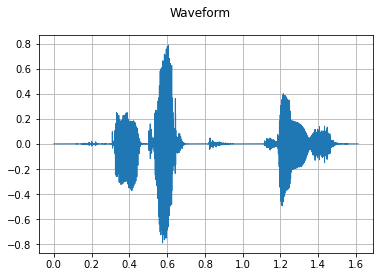

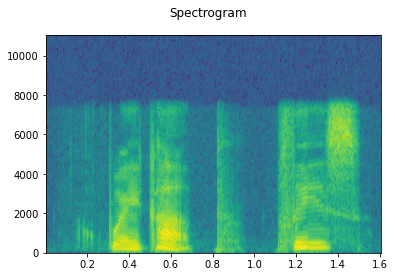

In [4]:
# 오디오 파일을 tensor로
waveform, sample_rate = torchaudio.load(audio_path)  # 기본 세팅이 normalize=True다. normalize=True일 경우 waveform이 [-1.0, 1.0]으로 normalize되어 반환된다

print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)

In [5]:
# fourier transform을 사용해 주파수 대역의 값을 얻으면 시간 대역의 정보를 잃어버린다. 사람이 말을 하면 시간별로 어떤 주파수 대역의 값이 많았는지 중요한데 이 시간정보를 잃어버린다는 뜻
# 그래서 시간을 x축, 주파수를 y축, 주파수별 값을 z축으로 하는 3차원 그래프를 spectrogram을 사용한다. 밝을 수록 해당 시간에서 해당 주파수대역의 값이 크다는 뜻으로 해석할 수 있겠다

n_fft = 1024 # fast fourier transform에서 사용할 주기의 크기. 신호를 win_length만큼 자른 뒤 n_fft에 맞게 0을 padding해주는데 그게 자른 신호의 앞에 할 수도 있고 뒤에 할 수도 있음
win_length = None # 신호를 자르는 단위? n_fft보다 작아야함. 
hop_length = 512

# define transformation
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)

# spectrogram -> waveform 변환에 사용됨
griffin_lim = T.GriffinLim(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)

Shape: (1, 513, 70)
Dtype: torch.float32
 - Max:     3850.237
 - Min:      0.000
 - Mean:     3.141
 - Std Dev: 59.977

tensor([[[1.8755e-06, 1.8575e-08, 3.7859e-08,  ..., 1.7028e-07,
          9.1845e-10, 2.8192e-06],
         [1.5187e-06, 5.8421e-07, 4.7805e-06,  ..., 6.0922e-07,
          1.6485e-06, 9.7005e-07],
         [1.8760e-06, 5.0562e-06, 1.3427e-05,  ..., 4.1760e-07,
          3.4513e-06, 1.1763e-06],
         ...,
         [8.9254e-09, 5.4147e-08, 1.6369e-08,  ..., 1.4405e-09,
          1.4866e-08, 9.0548e-08],
         [2.2995e-09, 1.4087e-07, 4.0770e-08,  ..., 9.2650e-09,
          1.4611e-08, 7.0624e-08],
         [3.1660e-08, 3.0865e-07, 9.7492e-08,  ..., 2.5410e-08,
          4.4694e-08, 1.6930e-09]]])



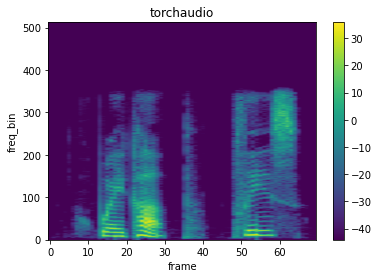

In [6]:
spec = spectrogram(waveform) 
recon_waveform = griffin_lim(spec) # 복원한거

print_stats(spec)
plot_spectrogram(spec[0], title="torchaudio") # 오른쪽 막대기가 z값인듯. 특정 주파수대역의 정도를 나타내는 값. 단위는 내가 알기로 dB다.

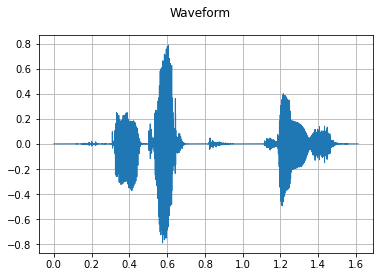

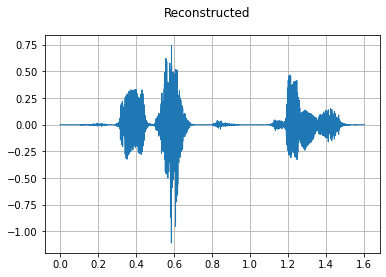

In [7]:
plot_waveform(waveform, sample_rate)
plot_waveform(recon_waveform, sample_rate, title="Reconstructed") # 조금 다르긴 하다

In [8]:
# 생각해보니 오디오를 처리하기 위해 RNN을 사용할 필요가 없었다. spectrogram을 사용하면 오디오도 이미지처럼 3차원 텐서가 나오는데 이미지 처리하듯 처리하면 되지 않을까? 
# 지금 당장 생각나는건 CLIP의 방식처럼 text encoder와 audio encoder를 같은 embedding space에 mapping시키는거다. 그러면 spectrogram -> [audio encoder] -> embedded vector -> [text decoder] -> text 의 흐름(?)을 만들 수 있지 않을까?

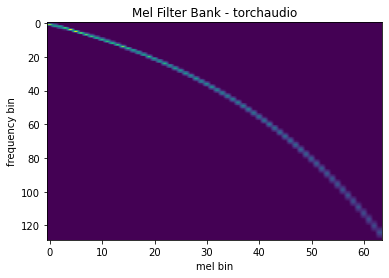

In [9]:
# Mel Filter Bank. 주파수를 mel-scale로 scaling하는데 쓰인다
# Mel spectrogram에 log를 취하는게 딥러닝에서 큰 의미를 갖는다고 한다. 

n_fft = 256
n_mels = 64
sample_rate = 6000

mel_filters = F.melscale_fbanks( # 여기서 F는 torchaudio.functional를 말한다
    int(n_fft // 2 + 1), # n_freq : 강조할? 아무튼 값을 살릴 주파수 대역의 개수
    n_mels=n_mels, # mel filterbanks의 개수
    f_min=0.0, # 최소 주파수
    f_max=sample_rate / 2.0, # 최대 주파수
    sample_rate=sample_rate,
    norm="slaney", # slaney일 경우 triangular mel weights를 width of the mel band로 나눈다
)
plot_mel_fbank(mel_filters, "Mel Filter Bank - torchaudio")

Shape: (1, 128, 70)
Dtype: torch.float32
 - Max:     524.875
 - Min:      0.000
 - Mean:     1.149
 - Std Dev: 12.947

tensor([[[3.1785e-07, 5.1774e-07, 1.6541e-06,  ..., 5.2367e-07,
          4.0194e-07, 1.8472e-07],
         [1.2121e-06, 5.0860e-06, 3.6724e-06,  ..., 2.0138e-05,
          7.8263e-07, 1.0128e-06],
         [8.4071e-06, 4.9875e-05, 7.3590e-06,  ..., 9.5557e-05,
          7.0632e-06, 6.1461e-06],
         ...,
         [2.3857e-09, 6.4604e-09, 7.1356e-09,  ..., 8.9093e-09,
          5.7332e-09, 3.3061e-09],
         [6.7164e-09, 8.8050e-09, 1.0094e-08,  ..., 5.0901e-09,
          4.5502e-09, 3.7248e-09],
         [7.5580e-09, 8.8601e-09, 8.2423e-09,  ..., 5.3935e-09,
          3.8661e-09, 7.3673e-09]]])



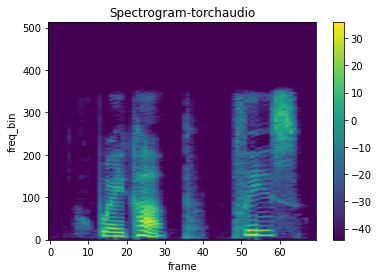

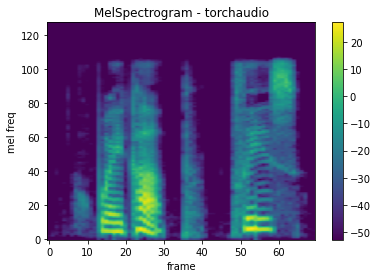

In [10]:
# 실제 Mel-spectrogram은 함수 하나로 구현할 수 있다. 
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(waveform)

print_stats(melspec)

# 모양은 거의 같은데 scale이 다른걸 알 수 있다
plot_spectrogram(spec[0], title="Spectrogram-torchaudio")
plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

Shape: (1, 256, 70)
Dtype: torch.float32
 - Max:     317.031
 - Min:     -596.383
 - Mean:    -1.929
 - Std Dev: 28.253

tensor([[[-5.9578e+02, -5.9496e+02, -5.9460e+02,  ..., -5.7951e+02,
          -5.9331e+02, -5.9638e+02],
         [ 1.0713e+00,  2.2216e+00,  2.5616e+00,  ...,  1.9990e+01,
           3.9370e+00,  2.1593e-01],
         [ 1.0613e+00,  2.1812e+00,  2.1357e+00,  ...,  9.9662e+00,
           2.2692e+00,  1.9051e-01],
         ...,
         [-2.7734e-02,  2.1368e-01,  2.0075e-01,  ..., -3.5885e-01,
           1.1076e-01, -1.0423e-01],
         [-1.9625e-02,  1.4528e-01,  1.9983e-01,  ..., -1.3744e-01,
           1.2960e-01, -8.0372e-02],
         [-8.6454e-03,  7.5014e-02,  1.3127e-01,  ..., -2.8191e-03,
           8.6183e-02, -4.2122e-02]]])



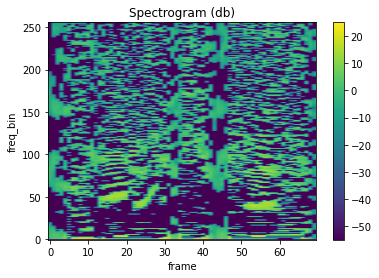

In [11]:
# MFCC(Mel-Frequency Cepstral Coefficient)라는 것도 pytorch에서 지원한다
# 소리의 고유 feature vector를 추출한다
# 인간의 귀 속에 있는 내이는 주파수에 따라 진동하는 부위가 다르며, 이를 이용해 소리를 분리해서 인식할 수 있다. 이를 모사하기 위해 MFCC가 생겼다
# 음성 인식에서 Mel-Spectrogram과 함께 빼놓을 수 없는 부분이라는 말도 있다
# MFCC는 mel-spectrogram에 log를 취하고 DCT를 적용한 뒤 선형 연산을 적용해야 한다고 한다. 복잡하다.
# MFCC와 mel-spectrogram의 main difference는 'log scale을 취하냐 안취하냐' 이다.
# 주파수 대역의 값은 지수가 없는데 로그를 취한다. 그래서 ln(0)과 같은 연산을 수행할 수 있는데 이 때 ln(0)을 그대로 연산하면 에러가 나니까 에러 방지를 위해 가짜값? 아무튼 그런걸 넣어준다. 그래서 정확한 값을 얻을 수 없다. 

n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(waveform)
print_stats(mfcc)
plot_spectrogram(mfcc[0])

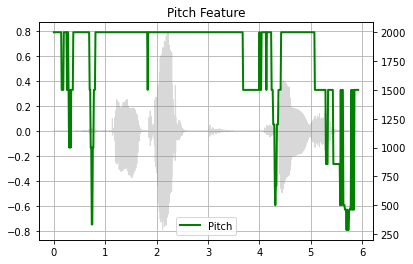

In [12]:
#  Pitch라는 것도 추출할 수 있나보다 
pitch = F.detect_pitch_frequency(waveform, sample_rate)
plot_pitch(waveform, sample_rate, pitch)